# Global mean Sea Surface Temperatures

**sst** - SST monthly mean (time: 492,lat: 720,lon: 1440)

**sst_Wmean** - SST weighted global mean (time)

**sst_Clim** - monthly climatology (month: 12lat: 720lon: 1440)

**sst_anom** - anomaly from monthly Climatology (time: 492, lat: 720,lon: 1440)

**sst_anom_Wmean** - SST anomlay weighted global mean (time: 492)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client
from dask import delayed
import dask

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = (10, 4)

#### Settings

In [2]:
year1=1982
year2=2023

In [3]:
#To compute de climatoloy
yearC1='1982'
yearC2='1992'

In [ ]:
HOME=os.environ['HOME']
USER=os.environ['USER']   

## Load data

In [5]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = HOME + '/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = './data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = HOME + '/Analisis/SSTGlobalAnalysis/data'

In [11]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]
DS = xr.open_mfdataset(files, chunks={'time': 100})

In [13]:
#titulo_short = 'GO'
#titulo = 'Global Ocean'
#sst = DS.sst.sel(lat=slice( -88, 88))

#titulo_short = 'NH'
#titulo = 'Northern hemisphere'
#sst = sst.sst.sel(lat=slice(0,88))

#titulo_short = 'SH'
#titulo = 'Southern hemisphere'
#sst = sst.sst.sel(lat=slice( -88, 0))

titulo_short = 'NAtl'
titulo = 'NorthAtlantic'
sst = DS.sst.sel(lat=slice(0, 80))

basins = xr.open_dataset('./data/basins.nc')
basin_surf = basins.basin[0]

basin_surf_interp = basin_surf.interp_like(sst, method='nearest')
sst = sst.where((basin_surf_interp==1) | (basin_surf_interp==4) ,drop=True)

### Resample data to 1 month

In [14]:
sst

<xarray.DataArray 'sst' (time: 15340, lat: 264, lon: 528)> Size: 9GB
dask.array<where, shape=(15340, 264, 528), dtype=float32, chunksize=(100, 264, 528), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
  * lat      (lat) float32 1kB 0.125 0.375 0.625 0.875 ... 65.38 65.62 65.88
  * lon      (lon) float32 2kB 0.625 0.875 1.125 1.375 ... 358.9 359.1 359.4
    Z        float32 4B 0.0
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

In [15]:
# Monthly mean
sst = sst.resample(time='ME').mean(dim='time',skipna=True).load()

## Global mean
(weigthed and unweigthed)

In [17]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [18]:
#Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [19]:
#Create anomaly
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.load();

## Global mean anomaly

In [20]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=12,center=True).mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Mean Sea Surface Temperature in the NorthAtlantic')

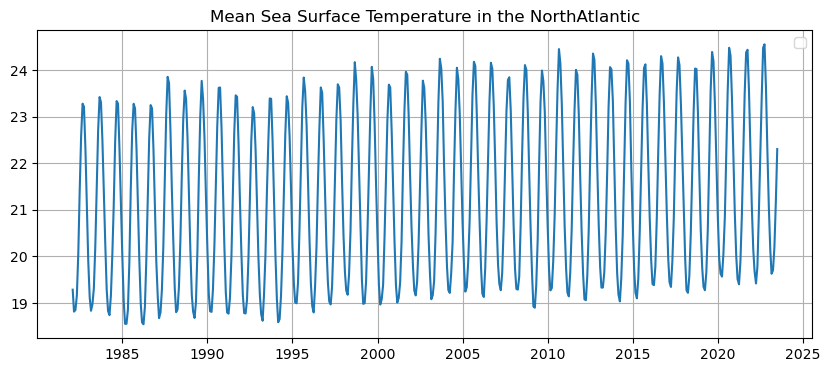

In [21]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sst_wmean.time,sst_wmean)
ax.grid()
ax.legend()
ax.set_title('Mean Sea Surface Temperature in the '+ titulo)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Mean Sea Surface Temperature anomaly in the NorthAtlantic\nAnomaly computed from 1982-1992')

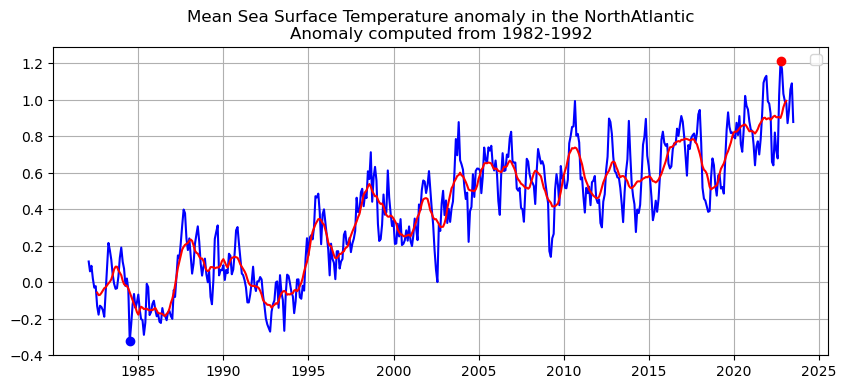

In [22]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sst_anom_wmean.time,sst_anom_wmean,'b')
ax.plot(sst_anom_wmean_rolling.time,sst_anom_wmean_rolling,'r')

ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmax(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmax(...)),'ro')
ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmin(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmin(...)),'bo')

ax.grid()
ax.legend()
ax.set_title('Mean Sea Surface Temperature anomaly in the '+ titulo + '\nAnomaly computed from 1982-1992')

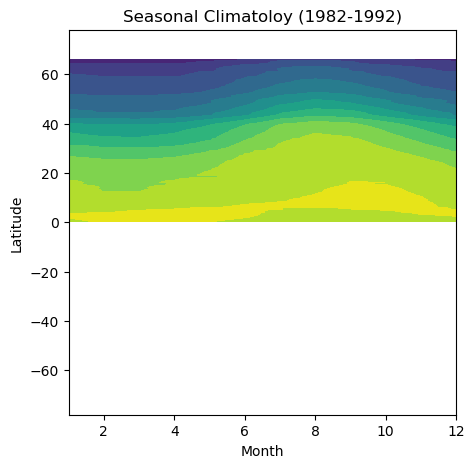

In [23]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(sst_clim.mean(dim='lon').month,
                 sst_clim.mean(dim='lon').lat,
                 sst_clim.mean(dim='lon').transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

In [26]:
sst.to_netcdf('./data/sstm_'+titulo_short+'.nc',mode='w')

In [27]:
sst_anom.to_netcdf(dataDir+'/sstm_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir+'/sstm_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir+'/sstm_anom_mean_'+titulo_short+'.nc',mode='w')

#sst_clim.to_netcdf('./data/sstm_clim_'+titulo_short+'.nc',mode='w')

## Annex A

### Compare weigthtened and unweigthtened global means

In [ ]:
#Calculate global mean unweigthtened
sst_UWmean = sst.mean(dim='lon',skipna=True).mean(dim='lat',skipna=True).load()

In [ ]:
sst_Wmean.plot(label="weighted")
sst_UWmean.plot(label="unweighted")
plt.grid()
plt.legend()

### Canary Islands example

In [ ]:
sst_NorteTenerife = sst.sel(lon=360-16.1188,lat=28.5559,method='nearest').load()
sst_anom_NorteTenerife = sst_anom.sel(lon=345,lat=29,method='nearest').load()
sst_anom_NorteTenerife_rolling = sst_anom.sel(lon=345,lat=29,method='nearest').rolling(time=12,center=True).mean()
sst_NorteTenerife_Y = sst_NorteTenerife.resample(time='1Y').mean(dim='time',skipna=True)

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(14,10))
ax.plot(sst_NorteTenerife.time,sst_NorteTenerife)
ax.grid()
ax.legend()
ax.set_title('Mean Sea Surface Temperature')

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(14,10))
ax.plot(sst_NorteTenerife_Y.time,sst_NorteTenerife_Y)
ax.grid()
ax.legend()
ax.set_title('Mean yearly Seaa Surface Temperature')
ax.plot(sst_NorteTenerife_Y.time.isel(sst_NorteTenerife_Y.argmax(...)),
           sst_NorteTenerife_Y.isel(sst_NorteTenerife_Y.argmax(...)),'ro')
ax.plot(sst_NorteTenerife_Y.time.isel(sst_NorteTenerife_Y.argmin(...)),
           sst_NorteTenerife_Y.isel(sst_NorteTenerife_Y.argmin(...)),'bo')

In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(14,8))
ax.plot(sst_anom_NorteTenerife.time,sst_anom_NorteTenerife,'b')
ax.plot(sst_anom_NorteTenerife_rolling.time,sst_anom_NorteTenerife_rolling,'r')
ax.plot(sst_anom_NorteTenerife.time.isel(sst_anom_NorteTenerife.argmax(...)),
           sst_anom_NorteTenerife.isel(sst_anom_NorteTenerife.argmax(...)),'ro')
ax.plot(sst_anom_NorteTenerife.time.isel(sst_anom_NorteTenerife.argmin(...)),
           sst_anom_NorteTenerife.isel(sst_anom_NorteTenerife.argmin(...)),'bo')
ax.legend()
ax.grid()
ax.set_title('Mean Sea Surface Temperature anomaly');